
<div style="text-align: center;">
    <h1>ReConPatch: anomaly detection</h1>
    <h3>Authors:</h3>
    <p>Dario Loi 1940849, Elena Muia 1938610, Martina Doku 1938629</p>

</div>


<div>
    <h2>0 - Introduction</h2>
    <p>This project aims to reimplement and potentially advance the ReConPatch method proposed in the paper titled  <a href="https://arxiv.org/pdf/2305.16713v3">”ReConPatch:
Anomaly Detection by Linear Modulation of Pretrained Features.”</a> This method addresses the challenge of
anomaly detection by constructing discriminative features through a linear modulation of patch features extracted
from pre-trained models and employs contrastive representation learning to collect and distribute features in a way
that produces a target-oriented and easily separable representation of the data.</p>
</div>


In [1]:
pip install ema-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 31.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5983 sha256=050ee88b6cc12858d63c3e4a376b70a575e19f0e388ca18ea4555ab772a00394
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from typing import Optional
from lightning import LightningDataModule, LightningModule
import lightning.pytorch as pl
import torch.optim as optim
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from ema_pytorch import EMA
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.optim.lr_scheduler import CosineAnnealingLR
from adamp import AdamP
import lightning.pytorch as torchpl
from torchvision.transforms import transforms
from sklearn import random_projection
import numpy as np

<div>
    <h2>1.1 - Data</h2>
    <p>In this study, we used the <a href="https://arxiv.org/pdf/2305.16713v3">MVTec AD</a> dataset
and <a href="https://arxiv.org/pdf/2305.16713v3">BTAD</a> dataset for our experiments</p>
</div>


In [5]:
#data
#downloaded from https://www.kaggle.com/uciml/pima-indians-diabetes-database
#!wget https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads/mvtec_anomaly_detection.tar.xz


<div>
    <h2>1.2 - Data preprocessing</h2>
    <p>We create a unique data module to feed to the lightning module for both the datasets. The preprocessing will follow the ones specified in the sections 4.3 and 4.4 of the aforementioned paper.</p>
</div>


In [6]:

class MVTecDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        batch_size: int = 16,
        num_workers: int = 4,
        train_val_split: float = 0.8,
        shuffle: bool = True,
        pin_memory: bool = True,
        image_size: int = 256,
        normalize: Optional[transforms.Normalize] = None,
        **kwargs,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_split = train_val_split
        self.shuffle = shuffle
        self.pin_memory = pin_memory
        self.image_size = image_size
        self.normalize = normalize

    def setup(self, stage=None):
        # Define transformations
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.CenterCrop(size=(224, 224)),
            self.normalize if self.normalize else transforms.Lambda(lambda x: x),
        ])
        transform_test = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.CenterCrop(size=(224, 224)),
        ]
        )

        # Load dataset
        tot_num=0
        for subclass in ["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]:
            dataset = ImageFolder(os.path.join(self.data_dir, subclass,"train"), transform=transform)
            test_dataset = ImageFolder(os.path.join(self.data_dir, subclass,"test"), transform=transform)
            # Split dataset into train and validation sets
            num_train = int(len(dataset) * self.train_val_split)
            num_val = len(dataset) - num_train
            tot_num+=len(dataset)
            train_dataset, val_dataset = torch.utils.data.random_split(
                dataset, [num_train, num_val])
            #print(subclass)
            #print('num_train',num_train)
            #print('num_val',num_val)
            #add the subclass to the dataset
            if subclass == "bottle":
                self.train_dataset = train_dataset
                self.val_dataset = val_dataset
                self.test_dataset = test_dataset
            else:
                self.train_dataset = torch.utils.data.ConcatDataset([self.train_dataset,train_dataset])
                self.val_dataset = torch.utils.data.ConcatDataset([self.val_dataset,val_dataset])
                self.test_dataset = torch.utils.data.ConcatDataset([self.test_dataset,test_dataset])

        #print the number of images in the dataset
        print("number of images in train dataset",len(self.train_dataset))
        print("number of images in val dataset",len(self.val_dataset))
        print("number of images in test dataset",len(self.test_dataset))


    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def test_dataloader(self):
#         # Load test dataset without shuffling
#         transform = transforms.Compose([
#             transforms.Resize((self.image_size, self.image_size)),
#             transforms.ToTensor(),
#             transforms.CenterCrop(size=(224, 224)),
#             self.normalize if self.normalize else transforms.Lambda(lambda x: x),
#         ])
#         for subclass in ["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]:
#             test_dataset = ImageFolder(os.path.join(self.data_dir, subclass,"test"), transform=transform)
#             if subclass == "bottle":
#                 self.test_dataset = test_dataset
#             else:
#                 self.test_dataset = torch.utils.data.ConcatDataset([self.test_dataset,test_dataset])

        return DataLoader(
            self.test_dataset,
            batch_size=2,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )
    def show_examples(self, dataloader, title):
        
        # Get a batch of samples
        images, labels = next(iter(dataloader))
        # Select one sample from the batch
        image = images[0]
        # Convert the tensor to a numpy array for displaying
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f'{title}')
        plt.show()

    def show_random_images(self, dataloader, title, num_images=10):
        fig, axs = plt.subplots(2, num_images // 2, figsize=(15, 8))
        axs = axs.flatten()

        # Randomly select images from the dataloader
        selected_indices = random.sample(range(len(dataloader.dataset)), num_images)
        
        for i, idx in enumerate(selected_indices):
            image, mask = dataloader.dataset[idx]
            image = image.permute(1, 2, 0).numpy()

            axs[i].imshow(image)
            axs[i].set_title(f'{title} - Image {i+1}')
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

In [7]:

import matplotlib.pyplot as plt
# Example usage
data_module = MVTecDataModule(data_dir='/kaggle/input/mvtec-ad')
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

'''
# Show examples
data_module.show_examples(train_loader, 'Training Example')
data_module.show_examples(val_loader, 'Validation Example')
data_module.show_examples(test_loader, 'Test Example')
'''


number of images in train dataset 2900
number of images in val dataset 729
number of images in test dataset 1725


"\n# Show examples\ndata_module.show_examples(train_loader, 'Training Example')\ndata_module.show_examples(val_loader, 'Validation Example')\ndata_module.show_examples(test_loader, 'Test Example')\n"

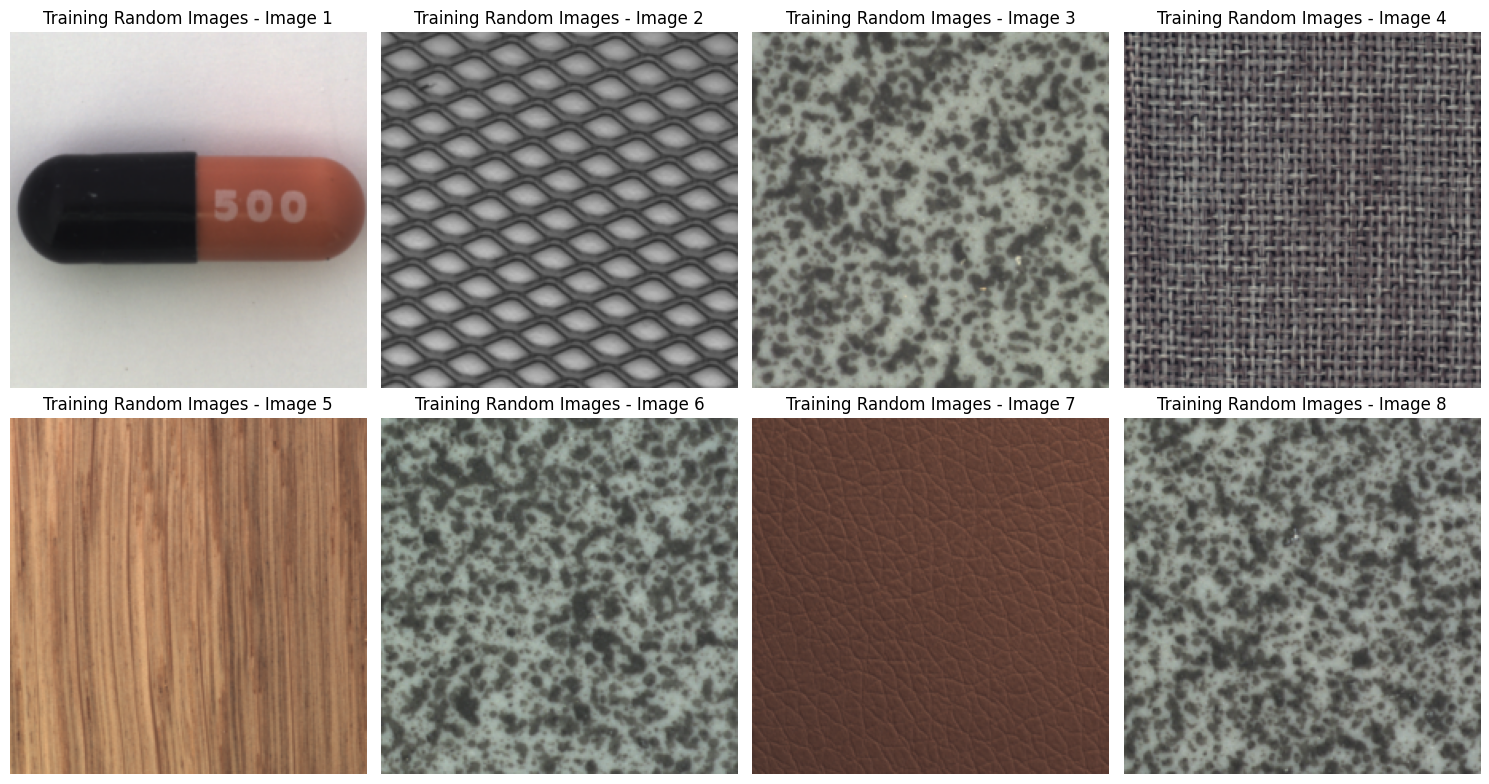

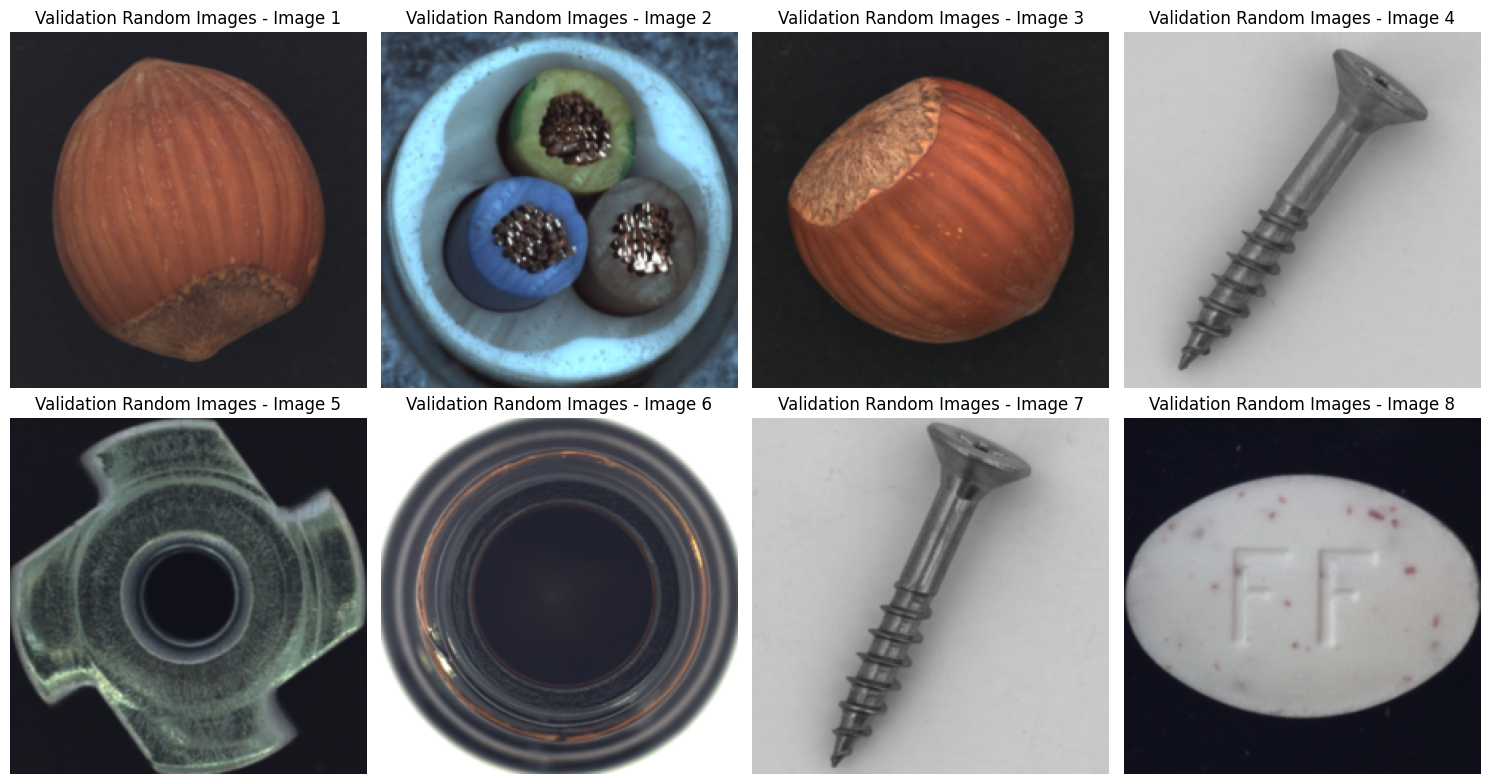

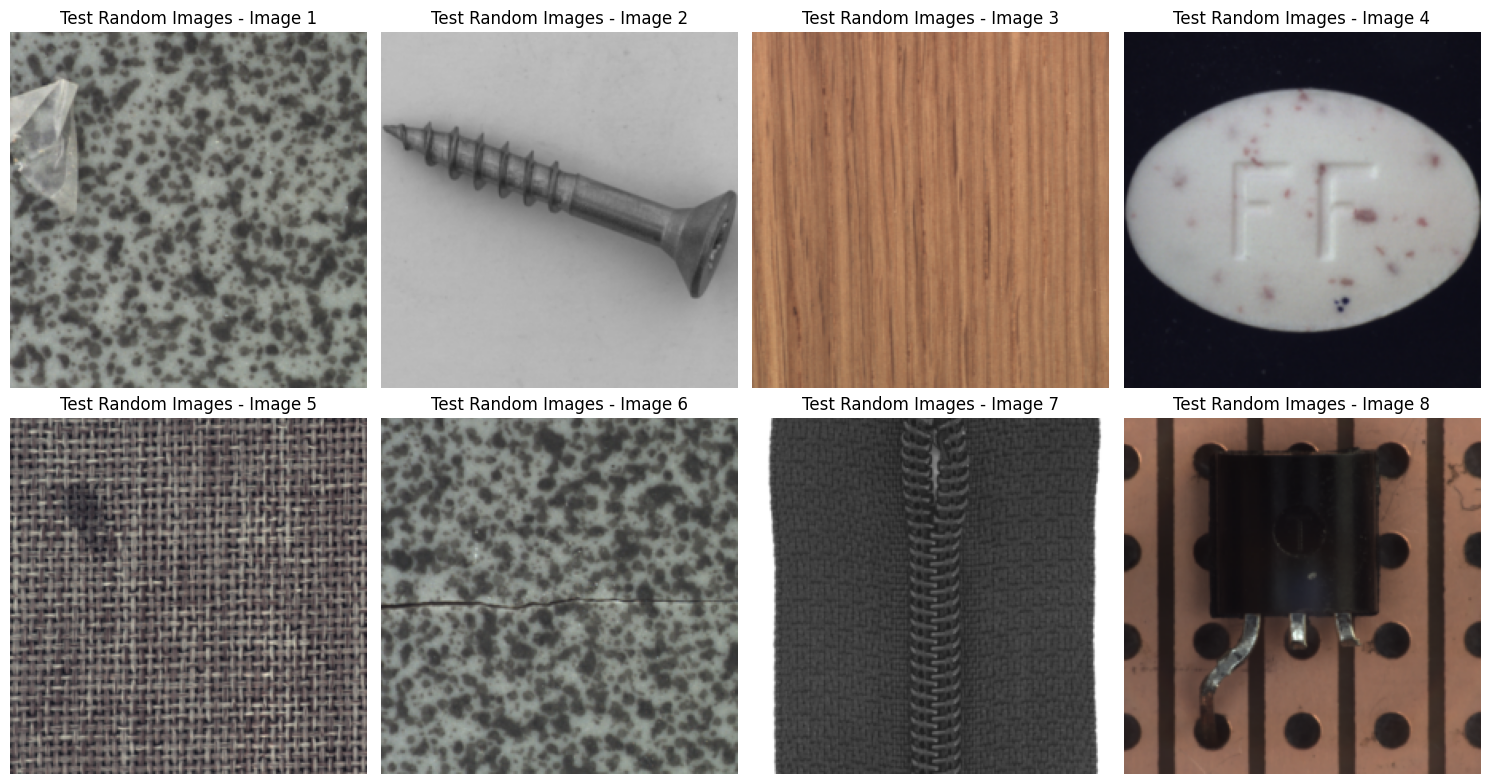

In [8]:
import random
# Show random images from the training dataloader
data_module.show_random_images(train_loader, 'Training Random Images', num_images=8)

# Show random images from the validation dataloader
data_module.show_random_images(val_loader, 'Validation Random Images', num_images=8)

# Show random images from the test dataloader
data_module.show_random_images(test_loader, 'Test Random Images', num_images=8)

In [9]:
# data_dir=os.path.join('/kaggle/input/mvtec-ad')
# datamod=MVTecDataModule(data_dir=data_dir,batch_size=4,num_workers=4,train_val_split=0.8,shuffle=True,pin_memory=True,image_size=256,normalize=None)
# datamod.setup()

In [10]:
#Algorithm defined in PatchCore paper
def obtainCoreset(
        memory_bank,
        l = 1000, 
        eps = 0.5,
        ):
    
    #random linear projection in lower dimension (more details in citation 49)
    memory_bank = memory_bank.detach().cpu().numpy()
    transformer = random_projection.SparseRandomProjection(eps=eps)
    memory_bank = torch.tensor(transformer.fit_transform(memory_bank))
    last_val = memory_bank[0]
    coreset_indices = [0]
    min_distances = torch.linalg.norm(memory_bank - last_val, dim= 1, keepdims = True)

    for _ in tqdm(range(l - 1)):
        distances = torch.linalg.norm(memory_bank - last_val, dim = 1, keepdims = True)
        min_distances = torch.minimum(distances, min_distances)
        index = torch.argmax(min_distances).item()       
        last_val = memory_bank[index]
        min_distances[index] = 0
        coreset_indices.append(index)
    return torch.tensor(coreset_indices)
    

In [11]:
def relaxedContrastiveLoss(w, delta, m): 
    return torch.mean(w * delta**2 + (1 - w) * torch.max(m - delta, torch.tensor(0.0))**2)


In [12]:
#We set \sigma = 1 based on the cited papers 18 and 19 in ReConPatch
class ContextualSimilarity(nn.Module):
    def __init__(self, k = 5, alpha = 0.5):
        super(ContextualSimilarity, self).__init__()
        self.k = k
        self.alpha = alpha
        
    def forward(self, z):
        distances = torch.cdist(z,z)  
        topk_dist = -torch.topk(-distances, self.k)[0][:,-1]
        filtering = (distances <= topk_dist.unsqueeze(-1)).float()
        similarity = torch.matmul(filtering, filtering.transpose(0, 1)) / torch.sum(filtering, dim=-1, keepdim=True)
        R = filtering * filtering.transpose(0, 1)
        similarity = torch.matmul(similarity, R.transpose(0, 1)) / torch.sum(R, dim=-1, keepdim=True)
        return self.alpha * (similarity + similarity.transpose(0, 1))
        
        
class PairwiseSimilarity(nn.Module):
    def __init__(self, sigma = 1.0):
        super(PairwiseSimilarity, self).__init__()
        self.sigma = sigma
    def forward(self,z):
        return torch.exp(-(torch.cdist(z,z)/self.sigma))


class ReConPatch(LightningModule):
    def __init__(
        self,
        input_dim = 1536,
        emb_dim = 512,
        proj_dim = 1024,
        alpha = 0.5,
        margin=0.1,
        
    ):  
        super(ReConPatch, self).__init__() 
        self.memory_bank = []
        self.memory_bank_sample = []
        
        self.fmap =[]
        
        #self.auroc = AUROC(task="multiclass", num_classes=15)
        self.margin = margin
        self.alpha = alpha

        self.frac_rate= 0.01
        self.eps_coreset = 0.5
        self.wr_model = torch.hub.load('pytorch/vision:v0.13.0', 'wide_resnet50_2', pretrained=True)
        
        def hook(module, input, output):
            self.fmap.append(output)
        self.wr_model.layer2.register_forward_hook(hook)            
        self.wr_model.layer3.register_forward_hook(hook)
        #setup network 1
        self.repr_layer = nn.Linear(input_dim, emb_dim)
        self.proj_layer = nn.Linear(emb_dim, proj_dim)
        
        #setup network 2
        self.repr_layer_2=nn.Linear(input_dim, emb_dim)
        self.proj_layer_2=nn.Linear(emb_dim, proj_dim)
        self.ema_repr = EMA(self.repr_layer_2)
        self.ema_proj = EMA(self.proj_layer_2) 
        #???
        with torch.no_grad():
            self.proj_layer.weight.copy_(torch.randn_like(self.proj_layer.weight))
            self.proj_layer.bias.copy_(torch.randn_like(self.proj_layer.bias))
            self.repr_layer.weight.copy_(torch.randn_like(self.repr_layer.weight))
            self.repr_layer.bias.copy_(torch.randn_like(self.repr_layer.bias))
        self.ema_repr.update()
        self.ema_proj.update()
        
        self.pairwise_sim=PairwiseSimilarity()
        self.contextual_sim=ContextualSimilarity()
    def forward(self, x):
        '''
        x has dimensions B x C x H x W (batch channels height width)
        '''
        #-----------FROM PRETRAINED MODEL TO FEATURE MAP
        self.fmap = []
        self.memory_bank_sample = []
        
        y = self.wr_model(x)
        
        #NOTE: We are taking as dimensions the ones of the feature map with higher resolution as specified in
        #chapter 3.1 of the patchcore paper (https://arxiv.org/pdf/2106.08265)
        dimensions = (
                int(torch.Tensor([t.shape[-2] for t in self.fmap]).max().item()),
                int(torch.Tensor([t.shape[-1] for t in self.fmap]).max().item())
            )
        
        blur = nn.AvgPool2d(3, stride = 1)
        resizer = nn.AdaptiveAvgPool2d(dimensions)
        preprocess = lambda t : resizer(blur(t))
        feature_stacks = torch.cat([preprocess(m) for m in self.fmap], dim=1)
        
        
        #-----------RECONPATCH
        feature_stacks_reshaped = feature_stacks.reshape(feature_stacks.shape[1], -1).T
        #feature_stacks_reshaped_cpu = feature_stacks_reshaped.detach().cpu().numpy()
        self.memory_bank_sample.append(feature_stacks_reshaped)
        
        
        #----------network1 pass
        h1=self.ema_repr(feature_stacks_reshaped)
        z1=self.ema_proj(h1)
        
        p_sim=self.pairwise_sim(z1)
        c_sim=self.contextual_sim(z1)
        
        w=self.alpha*p_sim+(1-self.alpha)*c_sim
        #----------network2 pass
        h2=self.repr_layer_2(feature_stacks_reshaped)
        z2=self.proj_layer_2(h2)
        
        
        pairwise_distances = torch.cdist(z2, z2, p=2)

        # Add a small epsilon to avoid division by zero when taking square root
        epsilon = 1e-9
        distances = torch.sqrt(pairwise_distances + epsilon)
        delta=distances/torch.mean(distances)
        
        return w ,delta
         
    def training_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        
        if self.frac_rate < 1:
            
            self.memory_bank_sample = torch.cat(self.memory_bank_sample, axis = 0)
            if self.memory_bank == []:
                self.memory_bank = self.memory_bank_sample
                mem_concat = self.memory_bank
            else:

                mem_concat = torch.cat([self.memory_bank,self.memory_bank_sample], axis = 0)
            
            num_coreset_points = int(self.frac_rate * mem_concat.shape[0])
            coreset_indices = obtainCoreset(mem_concat, l = num_coreset_points, eps = self.eps_coreset)
            self.memory_bank = mem_concat[coreset_indices]            
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamP(self.parameters(), lr=1e-6, betas=(0.9, 0.999), weight_decay=1e-2)
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  
        return [optimizer], [scheduler]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        w,delta = self(x)
        loss = relaxedContrastiveLoss(w, delta, self.margin)
        self.log('test_loss', loss)
        return loss

In [ ]:
wandb.login(key = '4e6b8c4cffac1d8cf8ca1a28ff5ef5d77333d2de')
wandb.init(project='ReConPatch')
wandb_logger = WandbLogger(project='ReConPatch')
                                     
reconpatch = ReConPatch()
trainer = pl.Trainer(
    max_epochs=1, 
    logger=wandb_logger, 
    callbacks=[
        torchpl.callbacks.ModelCheckpoint(
            monitor='val_loss', 
            save_top_k=1, 
            mode='min',
            save_last=True
        ),
        torchpl.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            mode="min"),
      ], 
    devices=[0],
)
trainer.fit(model=reconpatch, datamodule=data_module)

#close the wandb session
wandb.finish()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muia-1938610 (poi-dl-airo). Use `wandb login --relogin` to force relogin


Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 162MB/s]  
INFO: GPU available: True (cuda), used: True
INFO: TPU availa

number of images in train dataset 2900
number of images in val dataset 729
number of images in test dataset 1725


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type                 | Params
--------------------------------------------------------
0 | wr_model       | ResNet               | 68.9 M
1 | repr_layer     | Linear               | 786 K 
2 | proj_layer     | Linear               | 525 K 
3 | repr_layer_2   | Linear               | 786 K 
4 | proj_layer_2   | Linear               | 525 K 
5 | ema_repr       | EMA                  | 1.6 M 
6 | ema_proj       | EMA                  | 1.1 M 
7 | pairwise_sim   | PairwiseSimilarity   | 0     
8 | contextual_sim | ContextualSimilarity | 0     
--------------------------------------------------------
71.5 M    Trainable params
1.3 M     Non-trainable params
72.8 M    Total params
291.280   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 124/124 [00:01<00:00, 98.37it/s] 

100%|██████████| 125/125 [00:01<00:00, 71.38it/s]

100%|██████████| 125/125 [00:01<00:00, 116.33it/s]

100%|██████████| 125/125 [00:01<00:00, 118.12it/s]

100%|██████████| 125/125 [00:01<00:00, 121.03it/s]

100%|██████████| 125/125 [00:01<00:00, 117.99it/s]

100%|██████████| 125/125 [00:01<00:00, 92.74it/s] 

100%|██████████| 125/125 [00:01<00:00, 120.82it/s]

100%|██████████| 125/125 [00:01<00:00, 122.12it/s]

100%|██████████| 125/125 [00:01<00:00, 119.09it/s]

100%|██████████| 125/125 [00:01<00:00, 119.68it/s]

100%|██████████| 125/125 [00:01<00:00, 119.87it/s]

100%|██████████| 125/125 [00:01<00:00, 121.91it/s]

100%|██████████| 125/125 [00:01<00:00, 112.58it/s]

100%|██████████| 125/125 [00:01<00:00, 121.16it/s]

100%|██████████| 125/125 [00:01<00:00, 120.63it/s]

100%|██████████| 125/125 [00:01<00:00, 86.80it/s]

100%|██████████| 125/125 [00:01<00:00, 122.17it/s]

100%|██████████| 125/125 [00:01<00:00, 120.72it/s]

100%|████████

In [ ]:
#reconpatch = ReConPatch.load_from_checkpoint("/kaggle/input/checkpoint/epoch26-step9801.ckpt")

In [ ]:
mem_bank = reconpatch.memory_bank
mem_bank = torch.tensor(mem_bank)

In [ ]:
#reconpatch = ReConPatch()

In [ ]:
# sample, target = next(iter(datamod.train_dataloader()))
# with torch.no_grad():
#     y = reconpatch(sample)
#     mem_bank = reconpatch.memory_bank

In [ ]:
print(mem_bank)

In [ ]:
# feature_dim=len(reconpatch.fmap)
# l=len(datamod.train_dataloader())

# #memory_bank=torch.zeros(l,6272,1536)#dataloader_size,feature_reshaped_size
# for i, values in enumerate(tqdm(datamod.train_dataloader())): 
#     img,label=values
#     y = reconpatch(img)
#     feature_map = reconpatch.fmap
# #     print(feature_map)
#     dimensions = (
#                 int(torch.Tensor([t.shape[-2] for t in feature_map]).max().item()),
#                 int(torch.Tensor([t.shape[-1] for t in feature_map]).max().item())
#     )
#     blur = nn.AvgPool2d(3, stride = 1)
#     resizer = nn.AdaptiveAvgPool2d(feature_map[0].shape[-2])
#     preprocess = lambda t : resizer(blur(t))
#     feature_stacks = torch.cat([preprocess(m) for m in feature_map], dim=1)
#     feature_stacks_reshaped = feature_stacks.reshape(feature_stacks.shape[1], -1).T
#     print(feature_stacks_reshaped.shape)
#     break
#     memory_bank[i]=feature_stacks_reshaped

In [ ]:
# memory_bank = np.concatenate(memory_bank, axis = 0)

In [ ]:
# frac_rate= 0.01
# eps_coreset = 0.05
# if frac_rate < 1:
#     num_coreset_points = int(frac_rate * len(memory_bank))
#     coreset_indices = obtainCoreset(mem_bank, l=num_coreset_points, eps=eps_coreset)
#     mem_bankory = mem_bankory[coreset_indices]


In [ ]:
def anomalyDetection(batch_images):
  
    #Check if batch_images is a batch or a single image
    if batch_images.dim() == 3:
        batch_images = batch_images.unsqueeze(0)
        
    batch_size = batch_images.size(0)
    scores = []

    for i in range(batch_size):
        image = batch_images[i].unsqueeze(0)
        

        with torch.no_grad():
            y = reconpatch(image)
        feature_map = reconpatch.fmap
        dimensions = (
            int(torch.Tensor([t.shape[-2] for t in feature_map]).max().item()),
            int(torch.Tensor([t.shape[-1] for t in feature_map]).max().item())
        )

        blur = nn.AvgPool2d(3, stride=1)
        resizer = nn.AdaptiveAvgPool2d(dimensions)
        preprocess = lambda t: resizer(blur(t))
        feature_stacks = torch.cat([preprocess(m) for m in feature_map], dim=1)
        feature_stacks_reshaped = feature_stacks.reshape(feature_stacks.shape[1], -1).T.to('cuda')
        #feature_stacks_reshaped = feature_stacks_reshaped.to('cpu')
        #print(feature_stacks_reshaped)
    
        distances = torch.cdist(feature_stacks_reshaped, mem_bank, p=2)
        dist_val, dist_val_idxs = torch.min(distances, dim=1)
        
        s_idx = torch.argmax(dist_val)
        print(s_idx)
        s_star = torch.max(dist_val)
        m_test_star = torch.unsqueeze(feature_stacks_reshaped[s_idx], dim=0)
        m_star = mem_bank[dist_val_idxs[s_idx]].unsqueeze(0)

        knn_dists = torch.cdist(m_star, mem_bank, p=2.0)
        _, nn_idxs = knn_dists.topk(k=3, largest=False)

        m_star_neighbourhood = mem_bank[nn_idxs[0, 1:]]
        w_denominator = torch.linalg.norm(m_test_star - m_star_neighbourhood, dim=1)
        norm = torch.sqrt(torch.tensor(feature_stacks_reshaped.shape[1]))
        w = 1 - (torch.exp(s_star / norm) / torch.sum(torch.exp(w_denominator / norm)))
        s = w * s_star

        scores.append(s)

    return torch.stack(scores)

In [ ]:

img_list=[]
labels_list=[]
for img,label in tqdm(test_loader):
   
#     images_np = img.permute(0, 2, 3, 1).numpy()

# # # Creazione di una figura e di una griglia 2x2 per visualizzare le immagini
#     fig, axes = plt.subplots(1, 2, figsize=(8, 8))

     

#     for i, ax in enumerate(axes.flat):
#         ax.imshow(images_np[i])
#         ax.axis('off')  # Nascondere gli assi
#     plt.show()
  
    #print(type(img[0][0][0][0].item()))
    labels_list.append(label)
   
    probs = anomalyDetection(img)
    probs=probs.to('cpu')
    img_list.append(probs)


    

In [ ]:
print(img_list[400])

In [ ]:
# from torchmetrics import AUROC
# from sklearn.metrics import roc_auc_score
# print('img_list',len(img_list))
# print(img_list)
# print(labels_list)
# print('label_list_shape',len(labels_list))
# labels_list= torch.cat(labels_list,dim=0)
# img_list= torch.cat(img_list,dim=0)
# print(img_list)
# print(labels_list)
# auroc = AUROC(task="multiclass", num_classes=15)
# auroc.update(img_list, labels_list)
# auroc_value = auroc.compute()
# print(auroc_value.item())

In [ ]:
from sklearn.metrics import roc_auc_score
labels_list= torch.cat(labels_list,dim=0)
img_list= torch.cat(img_list,dim=0)
res = roc_auc_score(labels_list, img_list, multi_class ="ovr")
print(res)